# How we fine-tune transformers models for a specific task?

### Fine-tuning a Transformer model for a specific task typically involves the following steps:
- Prepare the task-specific data
- Tokenize the data
- Choose a pre-trained model
- Define a fine-tuning architecture
- Compile the model
- Train the model
- Evaluate the model

In [1]:
# install required libraries
# !pip install transformers
# !pip install pandas
# !pip install numpy
# !pip install seaborn
# !pip install scikit-learn
# !pip install torch


### 1. Prepare the task-specific data

#### Download Dataset

In [1]:
# download data from provided link
# !wget -nc https://www.dropbox.com/s/lkd0eklmi64m9xm/AirlineTweets.csv?dl=0

#### Import required libraries

In [2]:
# import required libraries
import pandas as pd
import numpy as np
import seaborn as sns

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

#### Load dataset

In [3]:
df = pd.read_csv('AirlineTweets.csv')

#### check how data looks like

In [4]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

#### Keep required columns only

In [6]:
df = df[['airline_sentiment','text']]

#### check data again

In [7]:
# As we can see, it has the 2 columns which we have selected.
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


#### Check the distribution of classes

<Axes: >

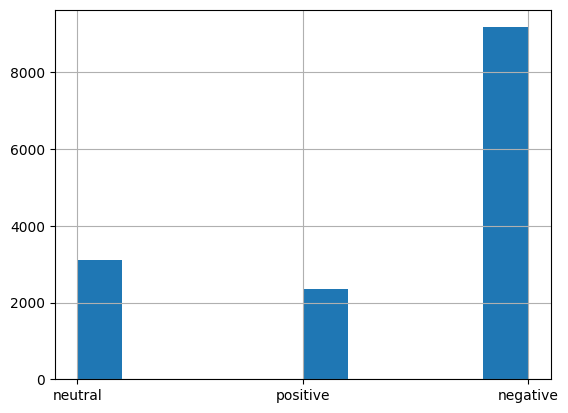

In [8]:
df['airline_sentiment'].hist()

#### Map classes to the integers

In [9]:
target_map = { 'positive': 1, 'negative': 0, 'neutral': 2}
df['target'] = df['airline_sentiment'].map(target_map)

Save data to new csv file. Because transformers required special format of dataset to perform operations on it, which we will give using load_dataset class. We will see next how dataset required for the transformers.

In [10]:
df1 = df[['text','target']]
df1.columns = ['sentence','label']
df1.to_csv('data.csv', index = False)

The resulting “data.csv” file will contain two columns, “sentence” and “label”, which are the pre-processed features for the text sequence and target label, respectively.

In [11]:
"""The “!pip install datasets” command installs the “datasets” library, which provides a unified API for accessing a variety of publicly available datasets 
for natural language processing tasks such as sentiment analysis, machine translation, and summarization."""
# !pip install datasets

'The “!pip install datasets” command installs the “datasets” library, which provides a unified API for accessing a variety of publicly available datasets \nfor natural language processing tasks such as sentiment analysis, machine translation, and summarization.'

In [12]:
# Imports the “load_dataset” function from the “datasets” library.
from datasets import load_dataset
# Uses the “load_dataset” function to load a dataset stored in a CSV file named “data.csv”, which we have stored above.
raw_dataset = load_dataset('csv', data_files = 'data.csv')

#______________________________________________________________
# if we have multiple csv files
# raw_dataset = load_dataset('csv', data_files = ['file1.csv','file2.csv'])

Generating train split: 0 examples [00:00, ? examples/s]

#### Check how loaded dataset looks like

In [13]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

#### Split dataset into train and test

In [14]:
split = raw_dataset['train'].train_test_split(test_size=0.25, seed=24)
#__________________________________________________________________
# raw_dataset = load_dataset('csv', 
#               data_files = { 'train': ['train1.csv','train2.csv'],
#                              'test': 'test.csv'})

In [15]:
#Check what we have got back
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10980
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 3660
    })
})

#### 2. Tokenize the data

In [16]:
# Import AutoTokenizer and create tokenizer object
from transformers import AutoTokenizer
checkpoint = 'bert-base-cased' #choose the model
tokernizer = AutoTokenizer.from_pretrained(checkpoint)

In [17]:
"""defines the function “tokenize_fn”, which takes a single argument “batch”. 
The “batch” argument is expected to be a dictionary-like object that contains the text data to be tokenized."""
# Define tokenizer function
def tokenize_fn(batch):
  return tokernizer(batch['sentence'], truncation = True)

In [18]:
"""returns the result of applying a tokenization function, “tokernizer”, to the “sentence” feature of the “batch” data. The “truncation” argument is set to “True”, 
which means that the tokenization function will truncate sequences that are longer than the maximum length specified by the model."""
tokenized_dataset = split.map(tokenize_fn, batched = True)
# After that we will get tokenized data which we can directly feed to our model.

Map:   0%|          | 0/10980 [00:00<?, ? examples/s]

Map:   0%|          | 0/3660 [00:00<?, ? examples/s]

#### Choose a pre-trained model

In [19]:
#Import classification model
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

#### Define a fine-tuning architecture

In [20]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 3)
# If you have a binary classification or sentiment analysis problem then use “num_labels” = 2.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# torchinfo is a Python library for getting information about PyTorch models and tensors. 
#!pip install torchinfo

In [22]:
# print the model summary
from torchinfo import summary
summary(model)
# Model has more than 108 M parameters and all they are trainable.

Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           2,307
Total params: 10

#### Compile the model

In [23]:
training_args = TrainingArguments(output_dir='training_dir',
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  num_train_epochs=3,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=64,
                                  )

In [24]:
#Define evaluation metrics, which we will pass during training
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average = 'micro')
  return {'accuracy': acc, 'f1_score': f1}

#### Train the model

In [25]:
trainer = Trainer(model,
                  training_args,
                   train_dataset = tokenized_dataset["train"],
                   eval_dataset = tokenized_dataset["test"],
                   tokenizer=tokernizer,
                   compute_metrics=compute_metrics)

C:\Users\lygov\AppData\Local\Programs\Python\Python311\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [26]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.555300,0.453812,0.834153,0.834153
2,0.368600,0.433212,0.845628,0.845628
3,0.147300,0.620139,0.848361,0.848361


Checkpoint destination directory training_dir\checkpoint-687 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory training_dir\checkpoint-1374 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory training_dir\checkpoint-2061 already exists and is non-empty. Saving will proceed but saved results may be invalid.


TrainOutput(global_step=2061, training_loss=0.3275891821804352, metrics={'train_runtime': 6876.875, 'train_samples_per_second': 4.79, 'train_steps_per_second': 0.3, 'total_flos': 822987937049544.0, 'train_loss': 0.3275891821804352, 'epoch': 3.0})

In [40]:
%ls training_dir
#As we can see there are 3 checkpoints, we will select first model as it has highest performance.

 Volume in drive C has no label.
 Volume Serial Number is BA26-48B2

 Directory of C:\Users\lygov\training_dir

17.03.2024  23:20    <DIR>          .
18.03.2024  10:33    <DIR>          ..
18.03.2024  00:52    <DIR>          checkpoint-1374
18.03.2024  01:30    <DIR>          checkpoint-2061
18.03.2024  00:13    <DIR>          checkpoint-687
18.03.2024  08:38    <DIR>          runs
               0 File(s)              0 bytes
               6 Dir(s)  99я614я834я688 bytes free


#### Evaluate the model

In [41]:
from transformers import pipeline

In [42]:
saved_model = pipeline('text-classification',
                       model = 'training_dir/checkpoint-2061')

#### Get test set

In [43]:
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 3660
})

#### Get predictions

In [44]:
predictions = saved_model(split['test']['sentence'])

In [45]:
#printout few predictions
predictions[:10]

[{'label': 'LABEL_0', 'score': 0.98883455991745},
 {'label': 'LABEL_0', 'score': 0.9988085031509399},
 {'label': 'LABEL_0', 'score': 0.9952859282493591},
 {'label': 'LABEL_0', 'score': 0.9989327788352966},
 {'label': 'LABEL_0', 'score': 0.9991657733917236},
 {'label': 'LABEL_1', 'score': 0.9917722344398499},
 {'label': 'LABEL_2', 'score': 0.9931364059448242},
 {'label': 'LABEL_0', 'score': 0.9992361068725586},
 {'label': 'LABEL_0', 'score': 0.9990823268890381},
 {'label': 'LABEL_0', 'score': 0.9849655628204346}]

In [46]:
def get_label(d):
  return int(d['label'].split('_')[1])
predictions = [get_label(d) for d in predictions]

In [47]:
print("acc:",accuracy_score(split['test']['label'], predictions))

acc: 0.8483606557377049


In [48]:
#Calculate f1 score
print("f1:",f1_score(split['test']['label'], predictions, average = 'macro'))

f1: 0.7991557254126255


#### Plot confusion matrix

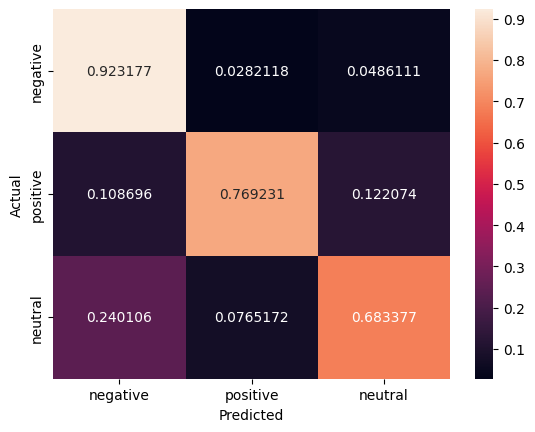

In [49]:
# create function for plotting confusion matrix
def plot_cm(cm):
  classes = ['negative','positive','neutral']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sns.heatmap(df_cm, annot = True, fmt='g')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

cm = confusion_matrix(split['test']['label'],predictions, normalize = 'true')
plot_cm(cm)

# Homework

### Simplified task: 
1) Find and use any model for sentimental text classification (with labels Positive, Negative, Neutral) on the already used dataset in notebook example
2) Compare metrics for your model and the bert fine-tuned model (accuracy and f1-score)

In [66]:
df = pd.read_csv('AirlineTweets.csv')[['airline_sentiment','text']]
target_map = { 'positive': 1, 'negative': 0, 'neutral': 2}

df_roberta = (df.assign(target = df['airline_sentiment'].map(target_map))
                .rename(columns={'text': 'sentence', 'target': 'label'}))

df_roberta.to_csv('data_roterta.csv', index = False)

In [67]:
df_roberta.head()

,airline_sentiment,sentence,label
0,neutral,@VirginAmerica What @dhepburn said.,2
1,positive,@VirginAmerica plus you've added commercials t...,1
2,neutral,@VirginAmerica I didn't today... Must mean I n...,2
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0


In [68]:
raw_dataset_roberta = load_dataset('csv', data_files = 'data_roterta.csv')

Generating train split: 0 examples [00:00, ? examples/s]

In [69]:
raw_dataset_roberta

DatasetDict({
    train: Dataset({
        features: ['airline_sentiment', 'sentence', 'label'],
        num_rows: 14640
    })
})

In [70]:
split_roberta = raw_dataset_roberta['train'].train_test_split(test_size=0.25, seed=24)

In [71]:
split_roberta

DatasetDict({
    train: Dataset({
        features: ['airline_sentiment', 'sentence', 'label'],
        num_rows: 10980
    })
    test: Dataset({
        features: ['airline_sentiment', 'sentence', 'label'],
        num_rows: 3660
    })
})

In [72]:
from transformers import RobertaTokenizer
checkpoint = 'roberta-base' 
tokernizer = RobertaTokenizer.from_pretrained(checkpoint)

In [73]:
def tokenize_fn(batch):
  return tokernizer(batch['sentence'], truncation = True)

In [74]:
tokenized_dataset = split_roberta.map(tokenize_fn, batched = True)

Map:   0%|          | 0/10980 [00:00<?, ? examples/s]

Map:   0%|          | 0/3660 [00:00<?, ? examples/s]

In [75]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['airline_sentiment', 'sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 10980
    })
    test: Dataset({
        features: ['airline_sentiment', 'sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 3660
    })
})

In [76]:
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments

model = RobertaForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [77]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                       Param #
RobertaForSequenceClassification                             --
├─RobertaModel: 1-1                                          --
│    └─RobertaEmbeddings: 2-1                                --
│    │    └─Embedding: 3-1                                   38,603,520
│    │    └─Embedding: 3-2                                   394,752
│    │    └─Embedding: 3-3                                   768
│    │    └─LayerNorm: 3-4                                   1,536
│    │    └─Dropout: 3-5                                     --
│    └─RobertaEncoder: 2-2                                   --
│    │    └─ModuleList: 3-6                                  85,054,464
├─RobertaClassificationHead: 1-2                             --
│    └─Linear: 2-3                                           590,592
│    └─Dropout: 2-4                                          --
│    └─Linear: 2-5                                           2,307
To

In [78]:
training_args = TrainingArguments(output_dir='training_dir_roberta',
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  num_train_epochs=3,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=64,
                                  )

In [79]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average = 'micro')
  return {'accuracy': acc, 'f1_score': f1}

In [80]:
trainer = Trainer(model,
                  training_args,
                  train_dataset = tokenized_dataset["train"],
                  eval_dataset = tokenized_dataset["test"],
                  tokenizer=tokernizer,
                  compute_metrics=compute_metrics)

C:\Users\lygov\AppData\Local\Programs\Python\Python311\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [81]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.556200,0.450012,0.825410,0.825410
2,0.410900,0.390924,0.852459,0.852459
3,0.230200,0.522211,0.860656,0.860656


TrainOutput(global_step=2061, training_loss=0.3754118725491172, metrics={'train_runtime': 7779.2194, 'train_samples_per_second': 4.234, 'train_steps_per_second': 0.265, 'total_flos': 748409672138688.0, 'train_loss': 0.3754118725491172, 'epoch': 3.0})

In [82]:
%ls training_dir_roberta

 Volume in drive C has no label.
 Volume Serial Number is BA26-48B2

 Directory of C:\Users\lygov\training_dir_roberta

18.03.2024  13:10    <DIR>          .
18.03.2024  13:11    <DIR>          ..
18.03.2024  12:28    <DIR>          checkpoint-1374
18.03.2024  13:10    <DIR>          checkpoint-2061
18.03.2024  11:48    <DIR>          checkpoint-687
18.03.2024  11:01    <DIR>          runs
               0 File(s)              0 bytes
               6 Dir(s)  94я092я693я504 bytes free


In [83]:
from transformers import pipeline


In [88]:
saved_model_roberta = pipeline('text-classification',
                       model='training_dir_roberta/checkpoint-2061')

In [89]:
split_roberta['test']

Dataset({
    features: ['airline_sentiment', 'sentence', 'label'],
    num_rows: 3660
})

In [90]:
predictions_roberta = saved_model_roberta(split_roberta['test']['sentence'])


In [91]:
def get_label(d):
  return int(d['label'].split('_')[1])
predictions_roberta = [get_label(d) for d in predictions_roberta]

In [92]:
from sklearn.metrics import accuracy_score, confusion_matrix

print("acc:",accuracy_score(split_roberta['test']['label'], predictions_roberta))

acc: 0.860655737704918


In [93]:
print("f1:",f1_score(split_roberta['test']['label'], predictions_roberta, average = 'macro'))


f1: 0.8168384510029906


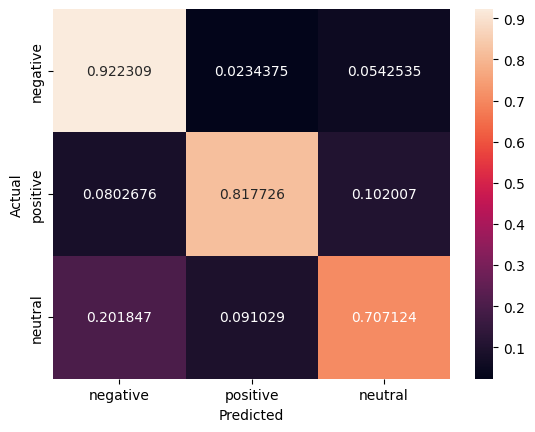

In [94]:
import seaborn as sns
# create function for plotting confusion matrix
def plot_cm(cm):
  classes = ['negative','positive','neutral']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sns.heatmap(df_cm, annot = True, fmt='g')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

cm = confusion_matrix(split_roberta['test']['label'],predictions_roberta, normalize = 'true')
plot_cm(cm)

### bert-base-cased model

- Accuracy score 0.8483606557377049
- F1 score 0.7991557254126255


### roberta-base model

- Accuracy score 0.860655737704918
- F1 score 0.8168384510029906

 The Roberta-base model is slightly better than the Bert-base-cased model.